# Investment Strategies
Create an investment strategy to beat the benchmark strategy.

### Product:
    FTSE 100 ETF - ISF

### Limit:
    £20,000 per year

### Rules:
    Atleast 4 investments per year

### Goal:
    Buy as many shares as possible
    
### Benchmark strategy:
    Pound cost averaging
    

#### Usefull links:
Inflation calculator:
https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go

import utils

import plotly.io as pio
pio.renderers.default = "png"


In [2]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'png'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

In [3]:
BASE_URL = 'https://docs.google.com/spreadsheets/d/10cihRP6XxJOSrWsASfW5C7VeHufD32TS0JKCXLoWhL8/export?format=csv&{}'

UKX_sheet = BASE_URL.format('gid=134530274')

ISF_sheet = BASE_URL.format('gid=1374752918')


In [4]:
# Read data
df = pd.read_csv(ISF_sheet)

# Rename columns
df = df.rename(columns={'Unnamed: 1': 'Open'})

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'].str[:10], format="%d/%m/%Y")

# Get datetime related fields
df['month'] = df['Date'].dt.month_name()
df['year'] = df['Date'].dt.year
df['day'] = df['Date'].dt.day
df['day_name'] = df['Date'].dt.day_name()
df['weekofyear'] = df['Date'].dt.weekofyear
df['is_quarter_end'] = df['Date'].dt.is_quarter_end
df['is_quarter_start'] = df['Date'].dt.is_quarter_start
df['quarter'] = df['Date'].dt.quarter
df['avg'] = round((df['High'] + df['Low']) / 2, 2) # $\frac{high + low}{2}$

# df = df.set_index('Date')

In [5]:
LIMIT = 2000000 # £20,000 per year
FEE = 995


# From 1999 to 2019, the average inflation was 2.7%
# https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator
INFLATION = 2.8


jan_2020_mean_price = df.loc[(df['year'] == 2020) & (df['month'] == 'January'), 'avg'].mean()

## Utility functions

In [6]:
def get_stats(strategy_df):
    tmp = strategy_df.copy()
    
    total_shares = tmp['shares'].sum()
    amount_invested = int((LIMIT * tmp.shape[0])/100)

    value = int((total_shares * jan_2020_mean_price)/100)
    profit = value - amount_invested
    value_increase = round((profit/amount_invested)*100, 2)

    print('Total no. of Shares:', int(total_shares))
    print('Amount invested: £{:,}'.format(amount_invested))
    print('Total value of Shares in Jan 2020: £{:,}'.format(value))
    print('Total profit in {} years: £{:,}'.format(tmp.shape[0], profit))
    print('Total value increased: {}%'.format(value_increase))

## Strategy 1 (Benchmark) - Pound Cost Averaging, first monday of every month
- This serves as the benchmark

In [7]:
monthly_limit = (LIMIT/12) - FEE

strategy_1 = (
        monthly_limit/(df
            .loc[
                df['Date'].isin(
                    df
                    .loc[(df['day_name'] == 'Monday') & (df['year'] >= 2001) & (df['year'] <= 2019), ['Date', 'year', 'month']]
                    .groupby(['year', 'month'])
                    .agg({'Date': min})
                    .reset_index()
                    .loc[:, 'Date']
                    .to_list()
                    ), 
                ['Date', 'avg']
            ]
        )    
        .set_index('Date')
    )

strategy_1 = strategy_1.reset_index()
strategy_1 = strategy_1.groupby(strategy_1['Date'].dt.year).sum().rename(columns={'avg': 'shares'})


In [8]:
strategy_1.tail()

,shares
Date,
2015,3016.652342
2016,3104.066541
2017,2718.113402
2018,2698.566427
2019,2783.042830


### Strategy Performance

In [9]:
get_stats(strategy_1)

Total no. of Shares: 66457
Amount invested: £380,000
Total value of Shares in Jan 2020: £495,486
Total profit in 19 years: £115,486
Total value increased: 30.39%


## Theoritcal Perfect Strategy (Upper Limit) - Buy at the lowest price every quarter
This serves as an upper limit of how many shares it is possible to buy if we bought at the lower price every quarter.

In [10]:
quarterly_limit = (LIMIT/4) - FEE

upper_limit = (    
        (
            quarterly_limit/(df
                .loc[(df['year'] >= 2001) & (df['year'] <= 2019)]
                .groupby(['year', 'quarter'])
                .agg({'Low': min})
                .reset_index()
                .set_index('year')
                .loc[:, ['Low']]
            )
        )
        .reset_index()
        .rename(columns={'Low': 'shares'})
        .groupby('year')
        .agg({'shares': 'sum'})
)


In [11]:
upper_limit.tail(3)

,shares
year,
2017,2813.301685
2018,2924.115972
2019,2905.515526


In [12]:
get_stats(upper_limit)

Total no. of Shares: 72195
Amount invested: £380,000
Total value of Shares in Jan 2020: £538,267
Total profit in 19 years: £158,267
Total value increased: 41.65%


## Theoritcal Worst Strategy (Lower Limit) - Buy at the highest price every quarter
This serves as an lower limit of how many shares can be bought if bought at the highest price every quarter.

In [13]:
quarterly_limit = (LIMIT/4) - FEE

lower_limit = (    
        (
            quarterly_limit/(df
                .loc[(df['year'] >= 2001) & (df['year'] <= 2019)]
                .groupby(['year', 'quarter'])
                .agg({'High': max})
                .reset_index()
                .set_index('year')
                .loc[:, ['High']]
            )
        )
        .reset_index()
        .rename(columns={'High': 'shares'})
        .groupby('year')
        .agg({'shares': 'sum'})
)

In [14]:
lower_limit.tail(3)

,shares
year,
2017,2656.761892
2018,2600.432537
2019,2667.975212


In [15]:
get_stats(lower_limit)

Total no. of Shares: 63288
Amount invested: £380,000
Total value of Shares in Jan 2020: £471,859
Total profit in 19 years: £91,859
Total value increased: 24.17%


## Strategies Performance Plots

In [16]:
result = pd.DataFrame(index=pd.date_range(start='2001-12-31', end='2019-12-31', freq='Y'))

result['strategy_1'] = strategy_1['shares'].to_list()
result['upper_limit'] = upper_limit['shares'].to_list()
result['lower_limit'] = lower_limit['shares'].to_list()

result.tail(3)

,strategy_1,upper_limit,lower_limit
2017-12-31,2718.113402,2813.301685,2656.761892
2018-12-31,2698.566427,2924.115972,2600.432537
2019-12-31,2783.042830,2905.515526,2667.975212


## No. of shares by year

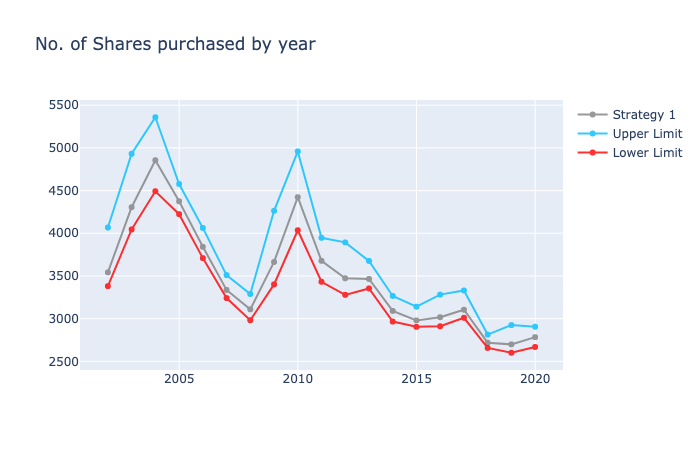

In [17]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['strategy_1'],
                name="Strategy 1",
                line_color='grey',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['upper_limit'],
                name="Upper Limit",
                line_color='deepskyblue',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['lower_limit'],
                name="Lower Limit",
                line_color='red',
                opacity=0.8)
             )


# Use date string to set xaxis range
fig.update_layout(
    title_text="No. of Shares purchased by year",
    # xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()

## Cumulative No. of Shares

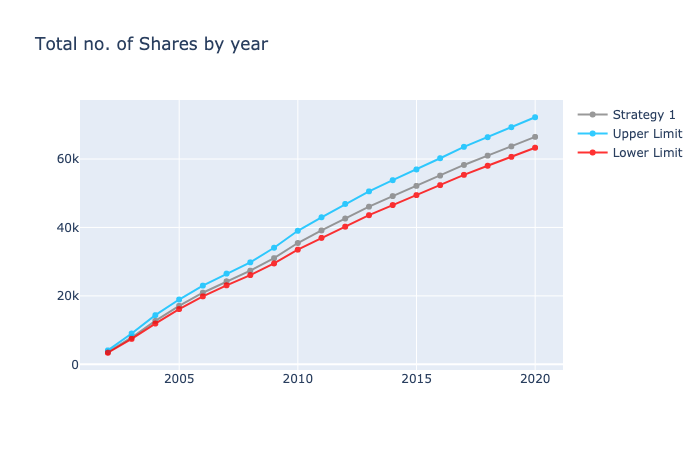

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['strategy_1'].cumsum(),
                name="Strategy 1",
                line_color='grey',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['upper_limit'].cumsum(),
                name="Upper Limit",
                line_color='deepskyblue',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=result.index,
                y=result['lower_limit'].cumsum(),
                name="Lower Limit",
                line_color='red',
                opacity=0.8)
             )

# Use date string to set xaxis range
fig.update_layout(
    title_text="Total no. of Shares by year",
#     xaxis_range=['2016-07-01','2016-12-31'],
)


fig.show()